# Know Thyself: Using Data Science to Explore Your Own Genome
## DNA analysis with pandas and Selenium

[23andme](https://www.23andme.com/) once offered me a free DNA and ancestry test kit if I participated in one of their clinical studies. In exchange for my genetic data and a bunch of questionnaires, I got my genome sequenced and gained access to myriad reports on where my ancestors were likely from, what health conditions and traits I probably have inherited, and who else on the site I might be related to.

While 23andme provides an overwhelming amount of consumer-ready infographics and tools, I wondered what else I could do with the data. I knew I could download my raw genetic data from the site in a text file, so I decided to pour it into pandas and see what I could make of it. 

In [1]:
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.color_palette('Spectral')
import matplotlib.pyplot as plt

In [62]:
import numpy as np
import requests
import pandas as pd

import re

In [3]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait

## Importing my DNA into pandas and exploring the genome

Looking at the .txt file, I could see that I was missing some genotype values, which were denoted with '--'. 

While most of the chromosomes are ints, there is an X and a Y (which I may convert later to a number for analytic purposes), but for now I need to make sure to specify the data type properly so that pandas doesn't throw an error when it sees mixed data in the input. 

The other columns are fairly straightforward. I also want pandas to ignore the prefatory comments at the beginning of the file that consist of lines beginning with an octothorpe.

The arguments I need to pass are:
* separator (tab-delimited)
* dtype (as a dict)
* na_values ('--')
* comment ('#')

![img](/genome.png)

In [4]:
data = pd.read_csv('genome.txt', sep='\t', dtype={'rsid':'str', 'chromosome':'object', 'position':'int', 'genotype':'str'}, comment='#')



In [5]:
print(data)

               rsid chromosome  position genotype
0       rs548049170          1     69869       TT
1        rs13328684          1     74792       --
2         rs9283150          1    565508       AA
3           i713426          1    726912       --
4       rs116587930          1    727841       GG
5         rs3131972          1    752721       AG
6        rs12184325          1    754105       CC
7        rs12567639          1    756268       AA
8       rs114525117          1    759036       GG
9        rs12124819          1    776546       AA
10       rs12127425          1    794332       GG
11       rs79373928          1    801536       TT
12       rs72888853          1    815421       --
13        rs7538305          1    824398       AA
14       rs28444699          1    830181       AA
15          i713449          1    830731       --
16      rs116452738          1    834830       GG
17       rs72631887          1    835092       TT
18       rs28678693          1    838665       TT


A quick note on the column names:

* rsid stands for Reference SNP cluster ID. It identifies unique SNPs.

* SNPs are Single Nucleotide Polymorphisms ('snips'), locations in the genome that are known to vary between individuals. They can influence disease risk, drug efficacy and side-effects, tell you about your ancestry, and predict aspects of how you look and act.

* All humans have almost the same sequence of 3 billion DNA bases (A,C,G, or T) distributed between their 23 pairs of chromosomes. But at certain locations there are differences that have been reported to be meaningful, either medically or for other reasons (such as for genealogy). The SNPedia catalogues SNPs that have significant medical consequences, are common, are reproducible (or found in meta-analyses or studies of at least 500 patients), or have other historic or medical significance.

I started off by navigating my new data frame with some basic exploratory data analysis and data cleaning.

In [6]:
# Read the data into a pandas DataFrame and do some EDA
df = pd.DataFrame(data)

In [7]:
df.head(25)

,rsid,chromosome,position,genotype
0,rs548049170,1,69869,TT
1,rs13328684,1,74792,--
2,rs9283150,1,565508,AA
3,i713426,1,726912,--
4,rs116587930,1,727841,GG
5,rs3131972,1,752721,AG
6,rs12184325,1,754105,CC
7,rs12567639,1,756268,AA
8,rs114525117,1,759036,GG
9,rs12124819,1,776546,AA


In [8]:
df.isna().any()

 rsid         False
chromosome    False
position      False
genotype      False
dtype: bool

In [9]:
df.nunique()

 rsid         638531
chromosome        25
position      634934
genotype          20
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638531 entries, 0 to 638530
Data columns (total 4 columns):
 rsid         638531 non-null object
chromosome    638531 non-null object
position      638531 non-null int64
genotype      638531 non-null object
dtypes: int64(1), object(3)
memory usage: 19.5+ MB


In [11]:
duplicates = df[df.duplicated(subset='position')]
display(duplicates.head())
display(duplicates.info())

,rsid,chromosome,position,genotype
449,i6059967,1,2526746,AA
2816,i6052145,1,11009679,GG
5325,i6012699,1,19992513,CC
5339,i6059797,1,20020994,TT
5791,i6058167,1,21795388,GG


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3597 entries, 449 to 638530
Data columns (total 4 columns):
 rsid         3597 non-null object
chromosome    3597 non-null object
position      3597 non-null int64
genotype      3597 non-null object
dtypes: int64(1), object(3)
memory usage: 140.5+ KB


None

In [12]:
# How many chromosomes am I missing by not having a Y chromosome?
Y_chromosome = df[df.chromosome == 'Y']

In [13]:
len(Y_chromosome)

3733

Since I don't have this chromosome, I'll just drop it from the DataFrame.

In [14]:
df = df[df.chromosome != 'Y']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634798 entries, 0 to 638530
Data columns (total 4 columns):
 rsid         634798 non-null object
chromosome    634798 non-null object
position      634798 non-null int64
genotype      634798 non-null object
dtypes: int64(1), object(3)
memory usage: 24.2+ MB


Most of the chromosomes are numeric; only X, Y, and mitochondrial are characters. I'll convert them to numbers, cast them to ints, and create a dictionary to translate back later so that the data will be more manipulable.

In [15]:
df['chromosome'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X',
       'MT'], dtype=object)

In [16]:
df['chromosome'] = df['chromosome'].apply(lambda x: re.sub(r'X', r'23', x))
df['chromosome'] = df['chromosome'].apply(lambda x: re.sub(r'MT', r'24', x))

In [17]:
df['chromosome'] = df['chromosome'].apply(lambda x: int(x))

In [18]:
chromosome_dict = {1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11', 12:'12', 13:'13', 
                  14:'14', 15:'15', 16:'16', 17:'17', 18:'18', 19:'19', 20:'20', 21:'21', 22:'22', 23:'X', 24:'MT'}

In [19]:
print(chromosome_dict)
display(df.info())

{1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: 'X', 24: 'MT'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 634798 entries, 0 to 638530
Data columns (total 4 columns):
 rsid         634798 non-null object
chromosome    634798 non-null int64
position      634798 non-null int64
genotype      634798 non-null object
dtypes: int64(2), object(2)
memory usage: 24.2+ MB


None

There are 16,005 genotypes that I simply do not have:

In [20]:
genotype_na = df[df.genotype == '--']
len(genotype_na)

16005

### Some visualizations

In [21]:
df[df.chromosome == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49514 entries, 0 to 49513
Data columns (total 4 columns):
 rsid         49514 non-null object
chromosome    49514 non-null int64
position      49514 non-null int64
genotype      49514 non-null object
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


In [22]:
# Remove that pesky whitespace from the column name
df.rename({' rsid': 'rsid'}, axis='columns', inplace=True)

How many SNPs are there per chromosome?

In [23]:
# We can do this manually with a for loop . . .
x = []
y = []
for k in chromosome_dict:
    x.append(k)
    y.append(len(df[df.chromosome == k]))
rsid_per_chromosome = dict(zip(x,y)) 

In [24]:
rsid_per_chromosome

{1: 49514,
 2: 51775,
 3: 43024,
 4: 39474,
 5: 37032,
 6: 44023,
 7: 34357,
 8: 31683,
 9: 26446,
 10: 30525,
 11: 30942,
 12: 29432,
 13: 22080,
 14: 19961,
 15: 19006,
 16: 20397,
 17: 19401,
 18: 17675,
 19: 14917,
 20: 14781,
 21: 8607,
 22: 8915,
 23: 16530,
 24: 4301}

In [25]:
# . . . but pandas makes it a lot easier!
rsid_per_chromosome_series = df.groupby('chromosome')['rsid'].count()
rsid_per_chromosome_series.columns = ['chromosome', 'count']

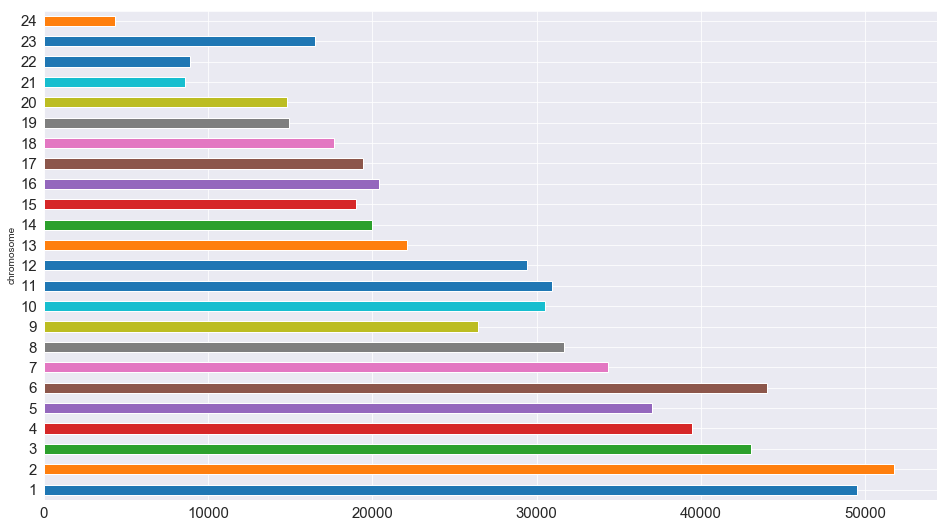

In [26]:
rsid_per_chromosome_series.plot.barh(figsize=(16,9), fontsize=15)
plt.show()

## Getting data on SNPs from SNPedia

To get some more info about my DNA, I pulled some information on clinically significant SNPs from SNPedia.

The columns are:

* Unnamed: 0 (actually the SNP name)
* Magnitude (a subjective measure of interest)
* Repute (a subjective measure of whether the genotype is "good" or "bad" to have based on research, and blank for things like ancestry and eye color)
* Summary (a narrative description)

In [27]:
snp_df = pd.read_csv('result.csv')
snp_df.head()

,Unnamed: 0,Magnitude,Repute,Summary
0,Rs661(A;A),9.0,Bad,early onset Alzheimer's disease
1,Rs6647(T;T),0.0,Good,Normal; two copies of Pi-M1V allele
2,Rs6647(C;C),0.0,Good,Normal; two copies of Pi-M1A allele
3,Rs1303(T;T),0.0,Good,common in clinvar
4,Rs28929471(G;G),0.0,Good,common in complete genomics


To match up with my original DataFrame, I'll create a genotype column and use regex to separate out the genotype, which is tacked onto the end of the SNP.

In [28]:
snp_df['genotype'] = snp_df['Unnamed: 0'].apply(lambda x: re.sub(r'.*([AGCT]);([AGCT])\)', r'\1\2', x))

In [29]:
snp_df.head()

,Unnamed: 0,Magnitude,Repute,Summary,genotype
0,Rs661(A;A),9.0,Bad,early onset Alzheimer's disease,AA
1,Rs6647(T;T),0.0,Good,Normal; two copies of Pi-M1V allele,TT
2,Rs6647(C;C),0.0,Good,Normal; two copies of Pi-M1A allele,CC
3,Rs1303(T;T),0.0,Good,common in clinvar,TT
4,Rs28929471(G;G),0.0,Good,common in complete genomics,GG


For consistency's sake, I renamed the columns to match my original DataFrame and made sure the rsids were all lower-case.

In [30]:
new_cols = ['rsid', 'magnitude', 'repute', 'summary', 'genotype']
snp_df.columns = new_cols

I'll use regex to clean up the rsid a little more, too.

In [31]:
snp_df['rsid'] = snp_df['rsid'].map(lambda x : x.lower())
snp_df['rsid'] = snp_df['rsid'].map(lambda x : re.sub(r'([a-z]{1,}[\d]+)\([agct];[agct]\)', r'\1', x))

In [32]:
snp_df.head()

,rsid,magnitude,repute,summary,genotype
0,rs661,9.0,Bad,early onset Alzheimer's disease,AA
1,rs6647,0.0,Good,Normal; two copies of Pi-M1V allele,TT
2,rs6647,0.0,Good,Normal; two copies of Pi-M1A allele,CC
3,rs1303,0.0,Good,common in clinvar,TT
4,rs28929471,0.0,Good,common in complete genomics,GG


In [33]:
snp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
rsid         100 non-null object
magnitude    100 non-null float64
repute       91 non-null object
summary      96 non-null object
genotype     100 non-null object
dtypes: float64(1), object(4)
memory usage: 4.0+ KB


Let's see what's going on with the null reputes and summaries and overwrite them if it's appropriate. (In this case, the answer seems to be yes.)

In [34]:
null_repute = snp_df[snp_df['repute'].isnull()]
null_summaries = snp_df[snp_df['summary'].isnull()]
null_repute_and_summaries = pd.concat([null_repute,null_summaries]).drop_duplicates().reset_index(drop=True)
display(null_repute_and_summaries)

,rsid,magnitude,repute,summary,genotype
0,rs28931569,4.0,NaN,high risk of emphysema,CC
1,rs28929473,0.0,NaN,NaN,TT
2,rs28931572,0.0,NaN,NaN,AA
3,rs1801252,3.0,NaN,NaN,GG
4,rs8192466,4.0,NaN,uncertain,TT
5,rs4986852,2.0,NaN,predisposition to breast cancer?,AA
6,rs1800709,2.0,NaN,predisposition to breast cancer?,TT
7,rs28931592,0.0,NaN,NaN,TT
8,rs4986893,2.1,NaN,poor metabolizer of several commonly prescribe...,AA


In [35]:
snp_df['repute'].fillna(value='Neutral', inplace=True)
snp_df['summary'].fillna(value='None', inplace=True)

In [36]:
# No no NaNette
snp_df.isna().any()

rsid         False
magnitude    False
repute       False
summary      False
genotype     False
dtype: bool

# Merging my data with SNPedia

Here, I've done an inner join of the SNPedia DataFrame on my DNA to see what data, if any, it has on my particular genotypes.

In [37]:
new_df = snp_df.merge(df, how='inner', on=['rsid', 'genotype'], suffixes=('_SNPedia', '_myDNA'))

In [38]:
new_df.head(20)

,rsid,magnitude,repute,summary,genotype,chromosome,position
0,rs1303,0.0,Good,common in clinvar,TT,14,94844843
1,rs17580,2.5,Bad,a slightly reduced functionality form of Alpha...,TT,14,94847262
2,rs28931580,0.0,Good,common in clinvar,AA,12,50344783
3,rs1042714,0.0,Good,normal,CC,5,148206473
4,rs1800888,0.0,Good,normal,CC,5,148206885
5,rs2303790,0.0,Good,common in clinvar,AA,16,57017292
6,rs5882,2.0,Bad,Faster aging. Increased risk for Dementia. Les...,AA,16,57016092
7,rs2230199,2.0,Bad,2.5x+ risk of ARMD,GG,19,6718387
8,rs28931608,0.0,Good,common in clinvar,GG,7,75614497
9,rs4986893,0.0,Good,normal,GG,10,96540410


### What's hiding in there?

In [39]:
# Create a DataFrame for some subsets of genes
good_genes = new_df[new_df.repute == 'Good']
bad_genes = new_df[new_df.repute == 'Bad']
interesting_genes = new_df[new_df.magnitude > 4] # 4 is the threshold for "worth your time" given by SNPedia

I have plenty of "good" genotypes, but none with a nonzero magnitude.

In [40]:
good_genes

,rsid,magnitude,repute,summary,genotype,chromosome,position
0,rs1303,0.0,Good,common in clinvar,TT,14,94844843
2,rs28931580,0.0,Good,common in clinvar,AA,12,50344783
3,rs1042714,0.0,Good,normal,CC,5,148206473
4,rs1800888,0.0,Good,normal,CC,5,148206885
5,rs2303790,0.0,Good,common in clinvar,AA,16,57017292
8,rs28931608,0.0,Good,common in clinvar,GG,7,75614497
9,rs4986893,0.0,Good,normal,GG,10,96540410
10,rs28399504,0.0,Good,normal,AA,10,96522463
11,rs2234922,0.0,Good,common in clinvar,AA,1,226026406
12,rs28931614,0.0,Good,common in clinvar,GG,4,1806119


I have three "bad" genotypes with a nonzero magnitude.

In [41]:
bad_genes

,rsid,magnitude,repute,summary,genotype,chromosome,position
1,rs17580,2.5,Bad,a slightly reduced functionality form of Alpha...,TT,14,94847262
6,rs5882,2.0,Bad,Faster aging. Increased risk for Dementia. Les...,AA,16,57016092
7,rs2230199,2.0,Bad,2.5x+ risk of ARMD,GG,19,6718387


Sadly I have no "interesting" genotypes above the threshold of 4, although I have some slightly interesting bad ones.

In [42]:
interesting_genes

,rsid,magnitude,repute,summary,genotype,chromosome,position


# Scrape relevant articles with Selenium

Now I'd like to read up on my bad genetics, so I'll use Selenium to grab the abstracts of some scientific papers for me from PubMed.

In [43]:
# Get the base URL from SNPedia
base_url = 'https://www.snpedia.com/index.php/'

In [90]:
# Create URLs for each gene that I want to study
gene_urls = [base_url + rsid for rsid in bad_genes['rsid']]
for url in gene_urls:
    print(url, '\n')

https://www.snpedia.com/index.php/rs17580 

https://www.snpedia.com/index.php/rs5882 

https://www.snpedia.com/index.php/rs2230199 



In [67]:
# Initialize Selenium
browser = webdriver.Chrome()

In [68]:
import time

In [81]:
# Write a function to visit the SNPedia URLs, click through to PubMed, 
# and retrieve the info on the articles for each gene

def scrape_abstracts(urls):
    
    #all_df = pd.DataFrame()
    rsid_list = []
    link_urls = []
    all_article_title = []
    all_article_citation = []
    all_article_authors = []
    all_article_abstract = []
    
    for url in urls:
        browser.get(url) #load url
        rsid = browser.find_element_by_css_selector('.firstHeading').text
        links_elements = browser.find_elements_by_partial_link_text('PMID')
        
    for link in links_elements:
        link_urls.append(link.get_attribute('href')) # get the URLs to the PubMed pages
    
    for element in link_urls:
        browser.get(element) # follow each link element to PubMed
        time.sleep(2)
        article_title = browser.find_element_by_xpath("//div[@class='cit']/../h1").text
        article_citation = browser.find_element_by_class_name('cit').text
        article_authors = browser.find_element_by_class_name('auths').text
        article_abstract = browser.find_element_by_class_name('abstr').text
            
        rsid_list.append(rsid)
        all_article_title.append(article_title)
        all_article_citation.append(article_citation)
        all_article_authors.append(article_authors)
        all_article_abstract.append(article_abstract)

    df = pd.DataFrame() # store the information
    df['rsid'] = rsid_list
    df['article_title'] = all_article_title
    df['article_citation'] = all_article_citation
    df['article_authors'] = all_article_authors
    df['article_abstract'] = all_article_abstract
    df['link'] = link_urls
        
    df = df.drop_duplicates()
        
    df.index = range(len(df.index))
       # pd.concat([all_df, df])
    
    return df

In [ ]:
abstracts_df = scrape_abstracts(gene_urls)

In [83]:
abstracts_df

,rsid,article_title,article_citation,article_authors,article_abstract,link
0,rs2230199,[Polymorphisms of complement factor genes and ...,Klin Monbl Augenheilkd. 2009 Aug;226(8):654-8....,"Baatz H1, Poupel L, Coudert M, Sennlaub F, Com...",Abstract\nBACKGROUND:\nAn association of the T...,https://www.ncbi.nlm.nih.gov/pubmed/19399715?d...
1,rs2230199,Complement component 3 (C3) haplotypes and ris...,Invest Ophthalmol Vis Sci. 2009 Jul;50(7):3386...,"Park KH1, Fridley BL, Ryu E, Tosakulwong N, Ed...",Abstract\nPURPOSE:\nNonsynonymous coding singl...,https://www.ncbi.nlm.nih.gov/pubmed/19234341?d...
2,rs2230199,Susceptibility genes and progression in age-re...,Invest Ophthalmol Vis Sci. 2010 Feb;51(2):731-...,"Farwick A1, Wellmann J, Stoll M, Pauleikhoff D...",Abstract\nPURPOSE:\nThe specific role of singl...,https://www.ncbi.nlm.nih.gov/pubmed/19797206?d...
3,rs2230199,Noncoding variant in the complement factor H g...,Invest Ophthalmol Vis Sci. 2010 Feb;51(2):1116...,"Cui L1, Zhou H, Yu J, Sun E, Zhang Y, Jia W, J...",Abstract\nPURPOSE:\nTo investigate whether the...,https://www.ncbi.nlm.nih.gov/pubmed/19850835?d...
4,rs2230199,Association of c3 gene polymorphisms with neov...,Curr Eye Res. 2009 Aug;34(8):615-22.,"Pei XT1, Li XX, Bao YZ, Yu WZ, Yan Z, Qi HJ, Q...",Abstract\nPURPOSE:\nThe purpose of this study ...,https://www.ncbi.nlm.nih.gov/pubmed/19899988?d...
5,rs2230199,Complement component 3: an assessment of assoc...,Mol Vis. 2010 Feb 10;16:194-9.,"McKay GJ1, Dasari S, Patterson CC, Chakravarth...",Abstract\nPURPOSE:\nA non-synonymous single nu...,https://www.ncbi.nlm.nih.gov/pubmed/20157618?d...
6,rs2230199,Genetic variants near TIMP3 and high-density l...,Proc Natl Acad Sci U S A. 2010 Apr 20;107(16):...,"Chen W1, Stambolian D, Edwards AO, Branham KE,...",Abstract\nWe executed a genome-wide associatio...,https://www.ncbi.nlm.nih.gov/pubmed/20385819?d...
7,rs2230199,Genome-wide association study of advanced age-...,Proc Natl Acad Sci U S A. 2010 Apr 20;107(16):...,"Neale BM1, Fagerness J, Reynolds R, Sobrin L, ...",Abstract\nAdvanced age-related macular degener...,https://www.ncbi.nlm.nih.gov/pubmed/20385826?d...
8,rs2230199,Genome-wide association identifies SKIV2L and ...,Genes Immun. 2010 Dec;11(8):609-21. doi: 10.10...,"Kopplin LJ1, Igo RP Jr, Wang Y, Sivakumaran TA...",Abstract\nAge-related macular degeneration (AM...,https://www.ncbi.nlm.nih.gov/pubmed/20861866?d...
9,rs2230199,Common variants near FRK/COL10A1 and VEGFA are...,Hum Mol Genet. 2011 Sep 15;20(18):3699-709. do...,"Yu Y1, Bhangale TR, Fagerness J, Ripke S, Thor...",Abstract\nDespite significant progress in the ...,https://www.ncbi.nlm.nih.gov/pubmed/21665990?d...


To save for later perusal, I'll export my web scrapings, complete with abstracts and hyperlinks, to a CSV file using the pandas DataFrame.to_csv method. 

In [ ]:
# DataFrame to CSV
export_csv = abstracts_df.to_csv(r'/Users/lorajohns/Documents/Python/DNA/DNA_articles.csv')

## Reading up on the medical literature

Now I have a handy CSV file, nicely formatted to read in Numbers, Excel, or PDF format, with citations to scientific articles analyzing and describing my genotypes with "significant" magnitudes and "bad" reputations. With the powerful tools Python provides, it's a great time to be alive for literal introspection. 